#Group 6 : Machine learning Project

## Objective: use sentiment analysis to compare to historical performance of stock's price

Dataset References: https://www.kaggle.com/datasets/gpreda/reddit-wallstreetsbets-posts/data

In [4]:
## Use this for consistency in graphs through out the notebook
import numpy as np
import pandas as pd

# to make this notebook's output stable across runs
np.random.seed(123)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
# plt.rcParams['axes.labelsize'] = 14
# plt.rcParams['xtick.labelsize'] = 12
# plt.rcParams['ytick.labelsize'] = 12

import seaborn as sns
import yfinance as yf

import nltk
nltk.download('punkt')
nltk.download('stopwords')

from wordcloud import WordCloud
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from collections import Counter

import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn.neighbors")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
# pip install matplotlib wordcloud nltk pandas

## 1. Data Preparation

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
pd.options.display.max_columns = None

#df = pd.read_csv('reddit_wsb.csv')
df = pd.read_csv("/content/drive/MyDrive/Deeplearning & ML UofT/Machine learning/project ML/reddit_wsb.csv")


In [8]:
df.shape

(53187, 8)

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53187 entries, 0 to 53186
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   title      53187 non-null  object 
 1   score      53187 non-null  int64  
 2   id         53187 non-null  object 
 3   url        53187 non-null  object 
 4   comms_num  53187 non-null  int64  
 5   created    53187 non-null  float64
 6   body       24738 non-null  object 
 7   timestamp  53187 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 3.2+ MB


In [10]:
df.head()

,title,score,id,url,comms_num,created,body,timestamp
0,"It's not about the money, it's about sending a...",55,l6ulcx,https://v.redd.it/6j75regs72e61,6,1.611863e+09,NaN,2021-01-28 21:37:41
1,Math Professor Scott Steiner says the numbers ...,110,l6uibd,https://v.redd.it/ah50lyny62e61,23,1.611862e+09,NaN,2021-01-28 21:32:10
2,Exit the system,0,l6uhhn,https://www.reddit.com/r/wallstreetbets/commen...,47,1.611862e+09,The CEO of NASDAQ pushed to halt trading “to g...,2021-01-28 21:30:35
3,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,l6ugk6,https://sec.report/Document/0001193125-21-019848/,74,1.611862e+09,NaN,2021-01-28 21:28:57
4,"Not to distract from GME, just thought our AMC...",71,l6ufgy,https://i.redd.it/4h2sukb662e61.jpg,156,1.611862e+09,NaN,2021-01-28 21:26:56


## 2. Data Exploration

### Feature explanations

> - Title: The title of the Reddit post.
> - Score: The Reddit score associated with the post, indicating the number of upvotes minus the number of downvotes (post's popularity).
> - Id: The unique identifier for each post.
> - Url: The URL of the post.
> - Comms_num: The number of comments on the post (engagement).
> - Created: The timestamp, expressed in epoch time format, of when the post was created.
> - Body: The text content of the post.
> - Timestamp: The timestamp of when the post was created.

In [11]:
df_explore = df.copy()
df_explore.set_index('timestamp', inplace=True)
df_explore = df_explore[['title', 'score', 'comms_num', 'body', 'id']]

In [12]:
df_explore.sample(5, random_state=0)

,title,score,comms_num,body,id
timestamp,,,,,
2021-02-03 03:18:10,'This is real' — Mark Cuban says Reddit trader...,6938,235,NaN,lb0yc1
2021-03-22 11:34:22,"You’re buying based on gut feeling, selling on...",4985,536,**Not a trading advise.**\n\nHey there folks a...,mabmyk
2021-04-14 01:55:40,"Anyone remember my 4/23C at 4,200? 5/7C and al...",33,10,NaN,mq3x2f
2021-02-04 14:03:33,Losing more and more . Picture is how i feel b...,58,22,NaN,lc70wr
2021-03-18 02:56:09,"$TR Tootsie Roll, $AMC and stimmi. Throw in a ...",45,23,NaN,m74wxe


In [13]:
# To understand how big the file is and how many variables it has
print('This dataframe has' ,df_explore.shape[0], 'rows and', df_explore.shape[1], 'columns')

This dataframe has 53187 rows and 5 columns


In [14]:
df_explore.info()

<class 'pandas.core.frame.DataFrame'>
Index: 53187 entries, 2021-01-28 21:37:41 to 2021-08-02 12:00:14
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   title      53187 non-null  object
 1   score      53187 non-null  int64 
 2   comms_num  53187 non-null  int64 
 3   body       24738 non-null  object
 4   id         53187 non-null  object
dtypes: int64(2), object(3)
memory usage: 2.4+ MB


- We can see that more of 50% of the 'body' feature are NULL
- Dates range are from January 28th, 2021 to August 2nd, 2021. Seven months of data.

**`Feature title`**
> Let's see what words/stocks are the most common


In [15]:
# Function to visualize the word cloud and word frequency for a given feature

def word_cloud(text_feature):
    titles = text_feature

    # Combining all titles into a single string
    all_titles = ' '.join(titles)

    # Tokenizing the text (process of breaking down a text into individual units)
    tokens = word_tokenize(all_titles)

    # Removing stopwords
    stop_words = set(stopwords.words('english')) # Creates a set of common English stop words (ex: 'and', 'to')
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words and word.isalpha()]

    # Word cloud
    word_cloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(filtered_tokens))

    # Word Cloud plot
    plt.figure(figsize=(10, 4))
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

   # Analyze Word Frequency
    word_freq = Counter(filtered_tokens)
    df_explore_word_freq = pd.DataFrame(list(word_freq.items()), columns=['Word', 'Frequency'])
    df_explore_word_freq = df_explore_word_freq.sort_values(by='Frequency', ascending=False)

    # Plot the top N words by frequency
    top_n = 15
    plt.figure(figsize=(15, 4))
    plt.bar(df_explore_word_freq['Word'][:top_n], df_explore_word_freq['Frequency'][:top_n], color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {top_n} Words in Titles')
    plt.show()

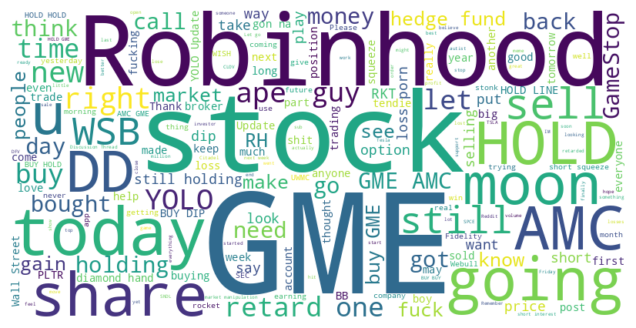

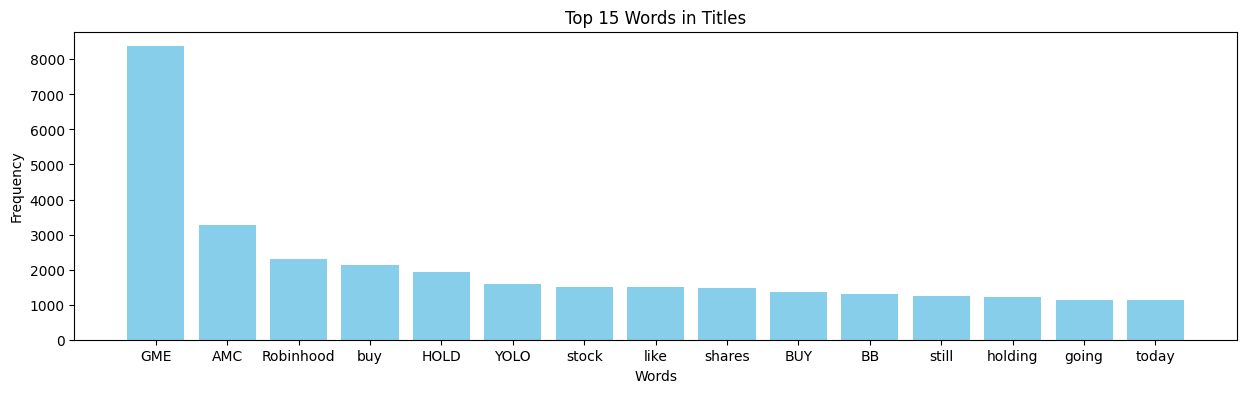

In [16]:
word_cloud(df_explore['title'])

**`Feature body`**
> We are going to repeat here the same exercise that we did for the feature 'title', to chatch the words/stocks that are more frequent

In [17]:
print('\033[1mThere are', df_explore['body'].isnull().sum(), 'nulls in the "body" column')


There are 28449 nulls in the "body" column


In [18]:
# We are going to use only the observations with texts in the 'body' column
df_body = df_explore[df_explore['body'].notnull()]
df_body.head(2)

,title,score,comms_num,body,id
timestamp,,,,,
2021-01-28 21:30:35,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,l6uhhn
2021-01-28 21:26:27,SHORT STOCK DOESN'T HAVE AN EXPIRATION DATE,317,53,Hedgefund whales are spreading disinfo saying ...,l6uf6d


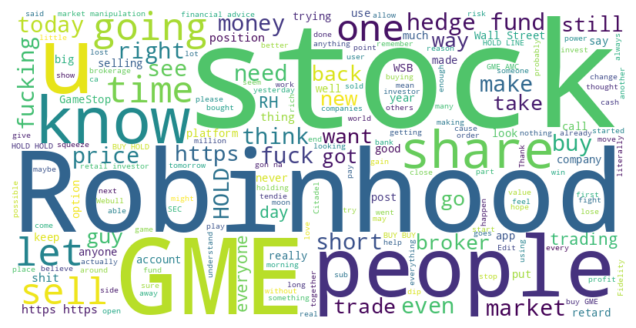

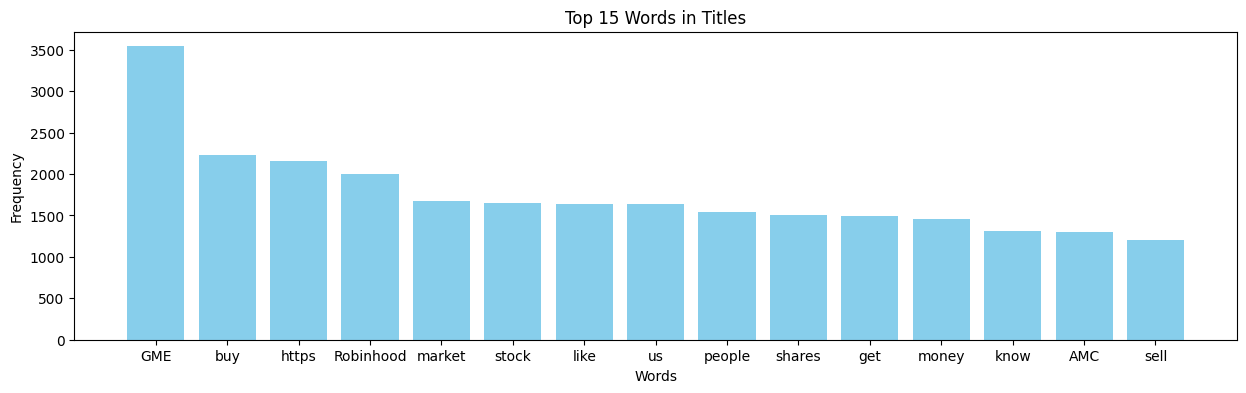

In [19]:
# Visualize in chunks for faster execution
word_cloud(df_body['body'].iloc[0:10000])

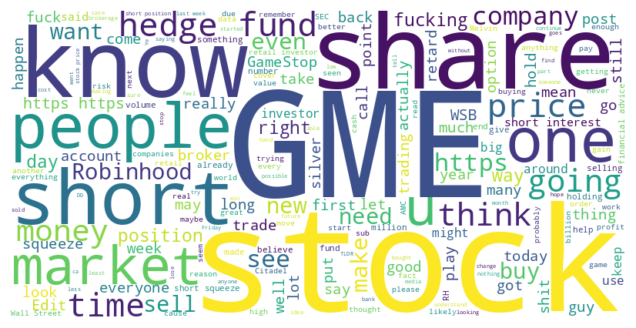

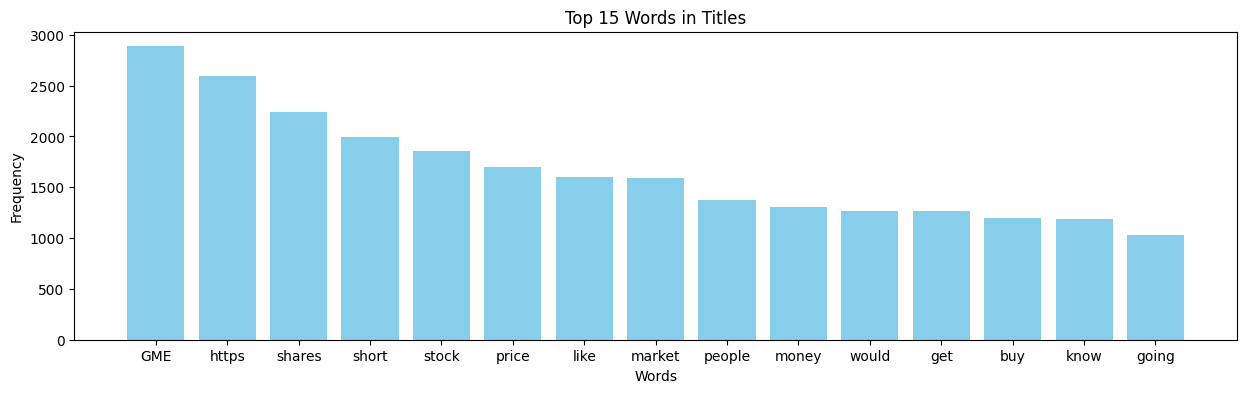

In [20]:
word_cloud(df_body['body'].iloc[10001:12000])

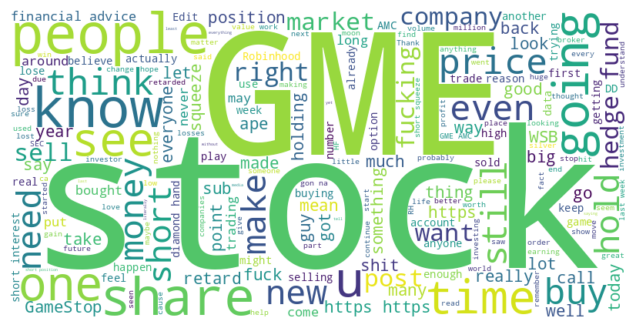

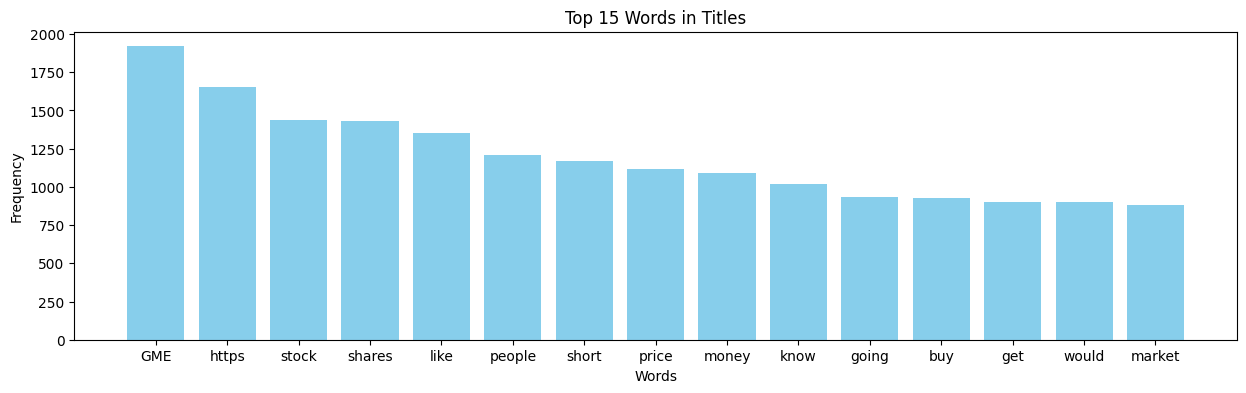

In [21]:
word_cloud(df_body['body'].iloc[12001:15000])

In [22]:
#word_cloud(df_body['body'].iloc[15001:18000])

In [69]:

#word_cloud(df_body['body'].iloc[18001:20000])

In [70]:
#word_cloud(df_body['body'].iloc[20001:25000])

**`Feature Score`**

In [23]:
df_explore['score'].unique()

array([   55,   110,     0, ...,  2997, 45436,  7398])

In [24]:
# Looking for negative values
df_explore[(df_explore['score'] <0)].sum()

title        0.0
score        0.0
comms_num    0.0
body         0.0
id           0.0
dtype: float64

In [25]:
df_explore['score'].describe()

count     53187.000000
mean       1382.461053
std        7999.271074
min           0.000000
25%           2.000000
50%          37.000000
75%         207.000000
max      348241.000000
Name: score, dtype: float64

In [26]:
# Which one is the post with so a high score
df_explore[df_explore['score']==348241]

,title,score,comms_num,body,id
timestamp,,,,,
2021-01-31 04:00:38,Times Square right now,348241,11554,NaN,l8rf4k


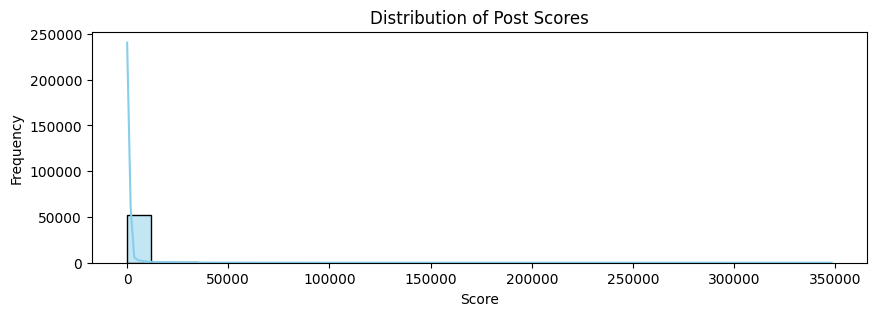

In [27]:
# Distribution plot for 'score'
plt.figure(figsize=(10, 3))
sns.histplot(df_explore['score'], bins=30, kde=True, color='skyblue')
plt.title('Distribution of Post Scores')
plt.xlabel('Score')
plt.ylabel('Frequency')
plt.show()

> We can see that lower scores are more frequent. Besides that, feature "scores" alone does not give much more information. We will try to find more insights by using the stock symbols that are more frequent in both columns, "title" and "body," and aggregating the data by date.

In [28]:
df_explore['body'] = df_explore['body'].fillna("")

In [29]:
df_explore

,title,score,comms_num,body,id
timestamp,,,,,
2021-01-28 21:37:41,"It's not about the money, it's about sending a...",55,6,,l6ulcx
2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...,110,23,,l6uibd
2021-01-28 21:30:35,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,l6uhhn
2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,,l6ugk6
2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",71,156,,l6ufgy
...,...,...,...,...,...
2021-08-02 15:03:27,What I Learned Investigating SAVA FUD Spreaders,238,87,***TLDR: Three bitter scientists partnered up ...,owd2pn
2021-08-02 15:01:03,"Daily Popular Tickers Thread for August 02, 20...",228,1070,\nYour daily hype thread. Please keep the shit...,owd1a5
2021-08-02 13:59:35,Hitler reacts to the market being irrational,7398,372,,owc5dr


In [30]:
# Stock symbols that appear more often on the dataset
stocks = ['GME', 'AMC', 'HOOD']

# Columns to search for stock symbols
columns = ['title', 'body']

# New column 'stock_symbol'
df_explore['stock_symbol'] = df_explore[columns].apply(lambda row: next((stock for stock in stocks if any(stock in cell for cell in row)), None), axis=1)
df_explore.head()

,title,score,comms_num,body,id,stock_symbol
timestamp,,,,,,
2021-01-28 21:37:41,"It's not about the money, it's about sending a...",55,6,,l6ulcx,None
2021-01-28 21:32:10,Math Professor Scott Steiner says the numbers ...,110,23,,l6uibd,None
2021-01-28 21:30:35,Exit the system,0,47,The CEO of NASDAQ pushed to halt trading “to g...,l6uhhn,GME
2021-01-28 21:28:57,NEW SEC FILING FOR GME! CAN SOMEONE LESS RETAR...,29,74,,l6ugk6,GME
2021-01-28 21:26:56,"Not to distract from GME, just thought our AMC...",71,156,,l6ufgy,GME


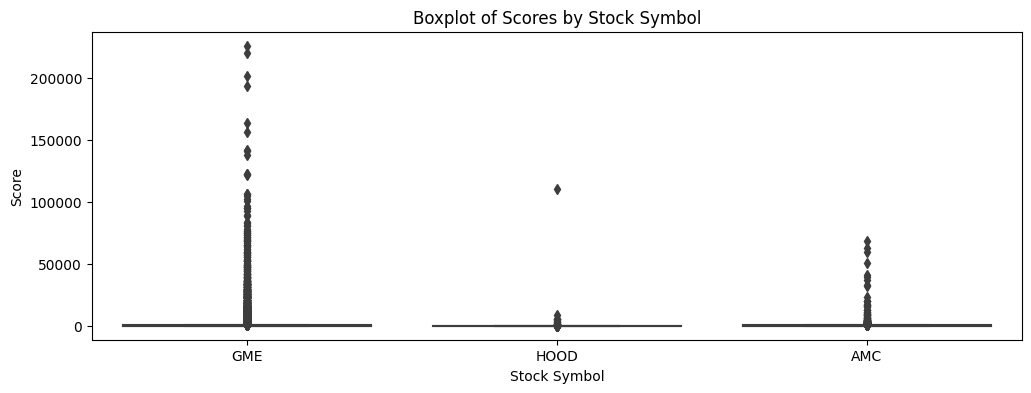

In [31]:
# Plot scores based on stock symbols
plt.figure(figsize=(12, 4))
sns.boxplot(x='stock_symbol', y='score', data=df_explore)
plt.title('Boxplot of Scores by Stock Symbol')
plt.xlabel('Stock Symbol')
plt.ylabel('Score')
plt.show()

In [32]:
# Convert 'timestamp' (index) to datetime
df_explore.index = pd.to_datetime(df_explore.index)

# Group by 'date' (extracted from the index) and 'stock_symbol' and calculate the mean score for each group
df_grouped = df_explore.groupby([df_explore.index.date, 'stock_symbol'])['score'].mean().reset_index()
df_grouped.rename(columns = {'level_0':'date'}, inplace = True)
df_grouped.head()

,date,stock_symbol,score
0,2021-01-28,AMC,775.586957
1,2021-01-28,GME,772.871795
2,2021-01-28,HOOD,82.000000
3,2021-01-29,AMC,21.960784
4,2021-01-29,GME,330.421670


In [33]:
# Pivot the DataFrame to have stock symbols as columns
df_pivot = df_grouped.pivot(index='date', columns='stock_symbol', values='score')

In [34]:
df_pivot.head()

stock_symbol,AMC,GME,HOOD
date,,,
2021-01-28,775.586957,772.871795,82.000000
2021-01-29,21.960784,330.421670,81.484241
2021-01-30,935.279070,4630.392578,944.769231
2021-01-31,2320.956522,3088.695431,15981.428571
2021-02-01,4237.310345,3519.669670,684.000000


In [35]:
df_pivot.shape

(175, 3)

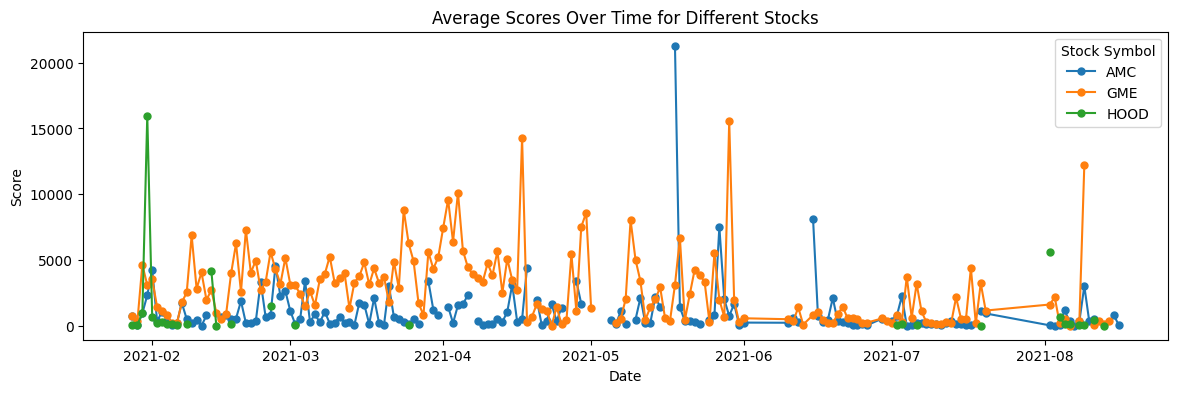

In [36]:
# Line plot for scores over time for each stock
plt.figure(figsize=(14,4 ))
df_pivot.plot(marker='o', markersize=5, ax=plt.gca())
plt.title('Average Scores Over Time for Different Stocks')
plt.xlabel('Date')
plt.ylabel('Score')
plt.legend(title='Stock Symbol')
plt.show()

**`Feature comms_num`**

In [37]:
df_explore['comms_num'].unique()

array([    6,    23,    47, ..., 13432,  9840, 11688])

In [38]:
df_explore['comms_num'].describe()

count    53187.000000
mean       263.260252
std       2532.665113
min          0.000000
25%          3.000000
50%         17.000000
75%         60.000000
max      93268.000000
Name: comms_num, dtype: float64

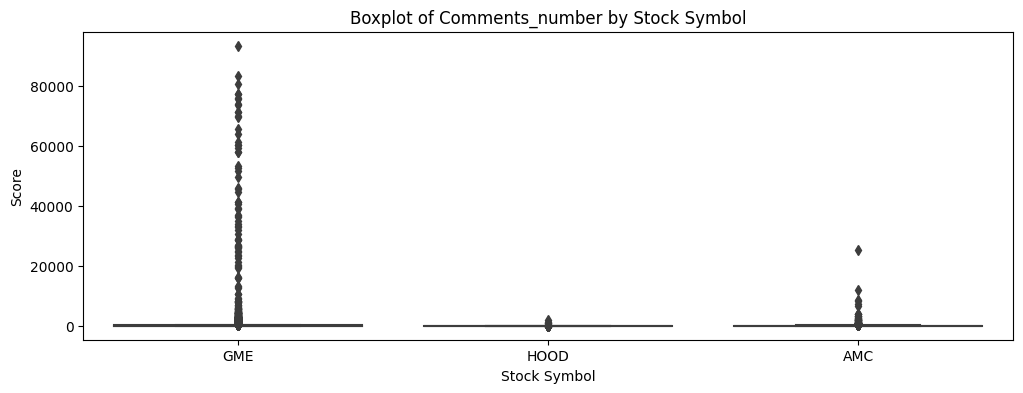

In [39]:
# Plot 'comms_num' based on stock symbols
plt.figure(figsize=(12, 4))
sns.boxplot(x='stock_symbol', y='comms_num', data=df_explore)
plt.title('Boxplot of Comments_number by Stock Symbol')
plt.xlabel('Stock Symbol')
plt.ylabel('Score')
plt.show()

In [40]:
# Group by 'date' (extracted from the index) and 'stock_symbol' and calculate the mean score for each group
df_grouped_2 = df_explore.groupby([df_explore.index.date, 'stock_symbol'])['score'].mean().reset_index()
df_grouped_2['comms_num'] = df_explore.groupby([df_explore.index.date, 'stock_symbol'])['comms_num'].mean().reset_index()['comms_num']

df_grouped_2.rename(columns = {'level_0':'date'}, inplace = True)
df_grouped_2.head()


,date,stock_symbol,score,comms_num
0,2021-01-28,AMC,775.586957,105.956522
1,2021-01-28,GME,772.871795,88.451282
2,2021-01-28,HOOD,82.000000,10.727273
3,2021-01-29,AMC,21.960784,6.734205
4,2021-01-29,GME,330.421670,67.054628


In [41]:
correlation_coefficient = df_explore['score'].corr(df_explore['comms_num'])
print(f"Correlation Coefficient: {correlation_coefficient}")

Correlation Coefficient: 0.1900268496606988


In [42]:
# Pivot the DataFrame to have stock symbols as columns
df_pivot_2 = df_grouped_2.pivot(index='date', columns='stock_symbol', values=['score', 'comms_num'])

In [43]:
df_pivot_2.head()

score                              comms_num              \
stock_symbol          AMC          GME          HOOD         AMC         GME   
date                                                                           
2021-01-28     775.586957   772.871795     82.000000  105.956522   88.451282   
2021-01-29      21.960784   330.421670     81.484241    6.734205   67.054628   
2021-01-30     935.279070  4630.392578    944.769231  145.860465  674.640625   
2021-01-31    2320.956522  3088.695431  15981.428571  247.304348  318.893401   
2021-02-01    4237.310345  3519.669670    684.000000  300.344828  524.378378   

                          
stock_symbol        HOOD  
date                      
2021-01-28     10.727273  
2021-01-29      8.194842  
2021-01-30     99.000000  
2021-01-31    374.285714  
2021-02-01    152.000000

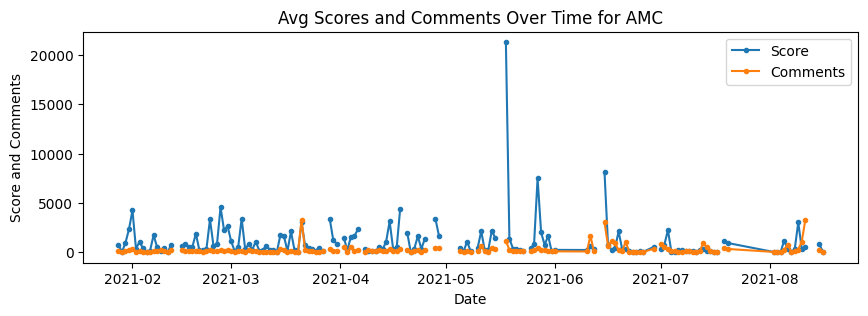

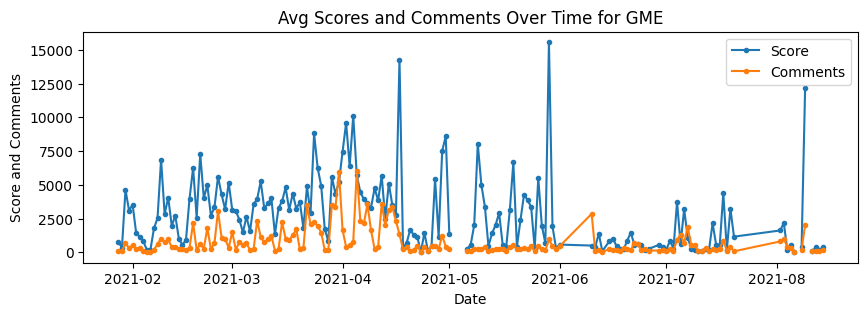

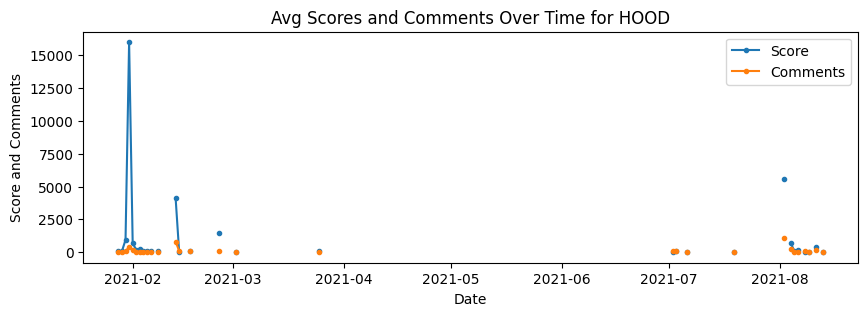

In [44]:
# # Pivot the DataFrame to have stock symbols as columns
# df_pivot_2 = df_grouped_2.pivot(index='date', columns='stock_symbol', values=['score', 'comms_num'])

# List of stock symbols
stock_symbols = df_grouped_2['stock_symbol'].unique()

# Plots for each 'stock_symbol' with both 'score' and 'comms_num' in the same axis
for stock_symbol in stock_symbols:
    plt.figure(figsize=(10, 3))

    # Plot 'score' over time
    plt.plot(df_pivot_2.index, df_pivot_2['score'][stock_symbol], marker='o', markersize=3, label='Score')

    # Plot 'comms_num' over time on the same axis
    plt.plot(df_pivot_2.index, df_pivot_2['comms_num'][stock_symbol], marker='o', markersize=3, label='Comments')

    plt.title(f'Avg Scores and Comments Over Time for {stock_symbol}')
    plt.xlabel('Date')
    plt.ylabel('Score and Comments')
    plt.legend()

    plt.show()

From the information above:
> - We have to Watch for the outliers for GME and AMC. Maybe they will have to be dropped later on the analysis
> - The correlation coefficient between 'score' and 'comms_num' is 0.19. With the help of the graphs, we can see a high correlation for GME in March and April. For the rest, it does not have any correlation.  



### Historical data to compare, from yahoo finance

Adding Historical data to see stock price change

In [45]:
# Stocks to download
stocks_list = ['AMC', 'GME', 'HOOD']
all_stocks = yf.download(stocks_list, start = ('2021-01-28'), end = ('2021-08-02'))

[*********************100%%**********************]  3 of 3 completed


In [46]:
all_stocks.columns

MultiIndex([('Adj Close',  'AMC'),
            ('Adj Close',  'GME'),
            ('Adj Close', 'HOOD'),
            (    'Close',  'AMC'),
            (    'Close',  'GME'),
            (    'Close', 'HOOD'),
            (     'High',  'AMC'),
            (     'High',  'GME'),
            (     'High', 'HOOD'),
            (      'Low',  'AMC'),
            (      'Low',  'GME'),
            (      'Low', 'HOOD'),
            (     'Open',  'AMC'),
            (     'Open',  'GME'),
            (     'Open', 'HOOD'),
            (   'Volume',  'AMC'),
            (   'Volume',  'GME'),
            (   'Volume', 'HOOD')],
           )

In [47]:
all_stocks.head()
# We will take the "Adjusted Close" price to use in our analysis

Adj Close                       Close                  \
                   AMC        GME HOOD         AMC        GME HOOD   
Date                                                                 
2021-01-28   86.300003  48.400002  NaN   86.300003  48.400002  NaN   
2021-01-29  132.600006  81.250000  NaN  132.600006  81.250000  NaN   
2021-02-01  133.000000  56.250000  NaN  133.000000  56.250000  NaN   
2021-02-02   78.199997  22.500000  NaN   78.199997  22.500000  NaN   
2021-02-03   89.699997  23.102501  NaN   89.699997  23.102501  NaN   

                  High                          Low                      Open  \
                   AMC         GME HOOD         AMC      GME HOOD         AMC   
Date                                                                            
2021-01-28  165.000000  120.750000  NaN   65.099998  28.0625  NaN  119.800003   
2021-01-29  160.000000  103.495003  NaN  116.000000  62.5000  NaN  143.100006   
2021-02-01  172.500000   80.500000  NaN  129.100006  53.0000  NaN  170.000000   
2021-02-02  101.000000   39.500000  NaN   60.000000  18.5550  NaN   94.800003   
2021-02-03   97.699997   28.350000  NaN   78.900002  21.3125  NaN   88.500000   

                              Volume                  
                  GME HOOD       AMC        GME HOOD  
Date                                                  
2021-01-28  66.250000  NaN  59122390  235263200  NaN  
2021-01-29  94.927498  NaN  60219330  202264400  NaN  
2021-02-01  79.139999  NaN  43460800  149528800  NaN  
2021-02-02  35.189999  NaN  46277590  312732400  NaN  
2021-02-03  28.002501  NaN  22140510  170794000  NaN

In [48]:
all_stocks_adj = all_stocks[[('Adj Close', 'AMC'), ('Adj Close', 'GME'), ('Adj Close', 'HOOD')]]
all_stocks_adj.head()

Adj Close                
                   AMC        GME HOOD
Date                                  
2021-01-28   86.300003  48.400002  NaN
2021-01-29  132.600006  81.250000  NaN
2021-02-01  133.000000  56.250000  NaN
2021-02-02   78.199997  22.500000  NaN
2021-02-03   89.699997  23.102501  NaN

In [49]:
# Merge the two dataframes based on the date index
df_merged = pd.merge(df_pivot_2, all_stocks_adj, left_index=True, right_index=True)
df_merged.head()

score                            comms_num              \
stock_symbol          AMC          GME        HOOD         AMC         GME   
2021-01-28     775.586957   772.871795   82.000000  105.956522   88.451282   
2021-01-29      21.960784   330.421670   81.484241    6.734205   67.054628   
2021-02-01    4237.310345  3519.669670  684.000000  300.344828  524.378378   
2021-02-02     338.560000  1425.706161  182.500000   64.180000  216.886256   
2021-02-03    1070.677778  1143.230000  255.000000   83.055556  277.930000   

                           Adj Close                  
stock_symbol        HOOD         AMC        GME HOOD  
2021-01-28     10.727273   86.300003  48.400002  NaN  
2021-01-29      8.194842  132.600006  81.250000  NaN  
2021-02-01    152.000000  133.000000  56.250000  NaN  
2021-02-02     27.500000   78.199997  22.500000  NaN  
2021-02-03     35.750000   89.699997  23.102501  NaN

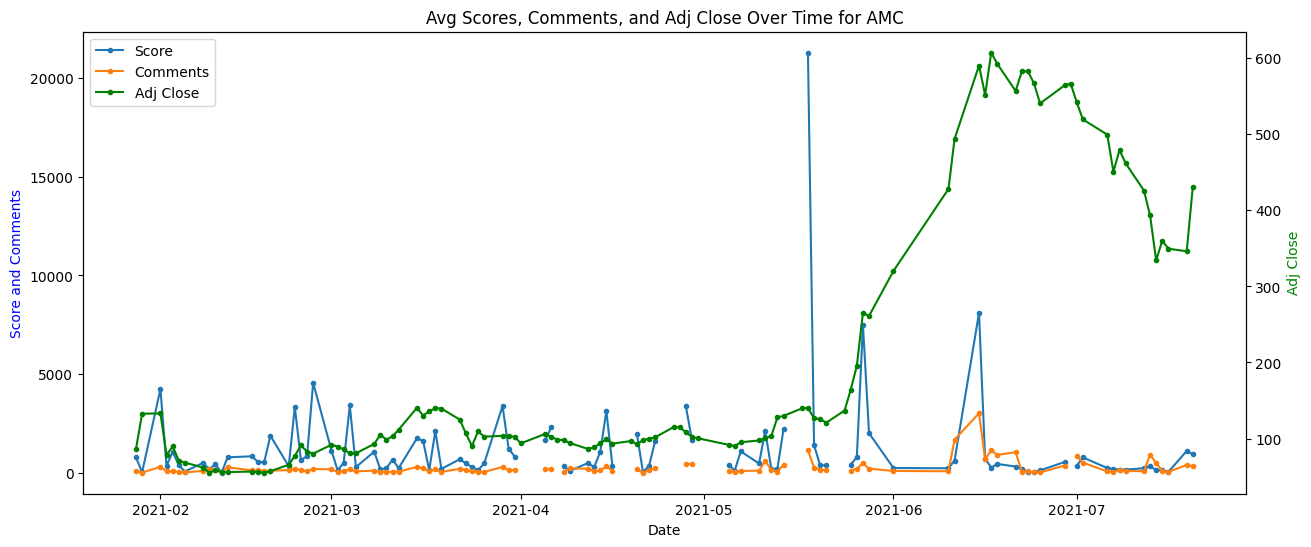

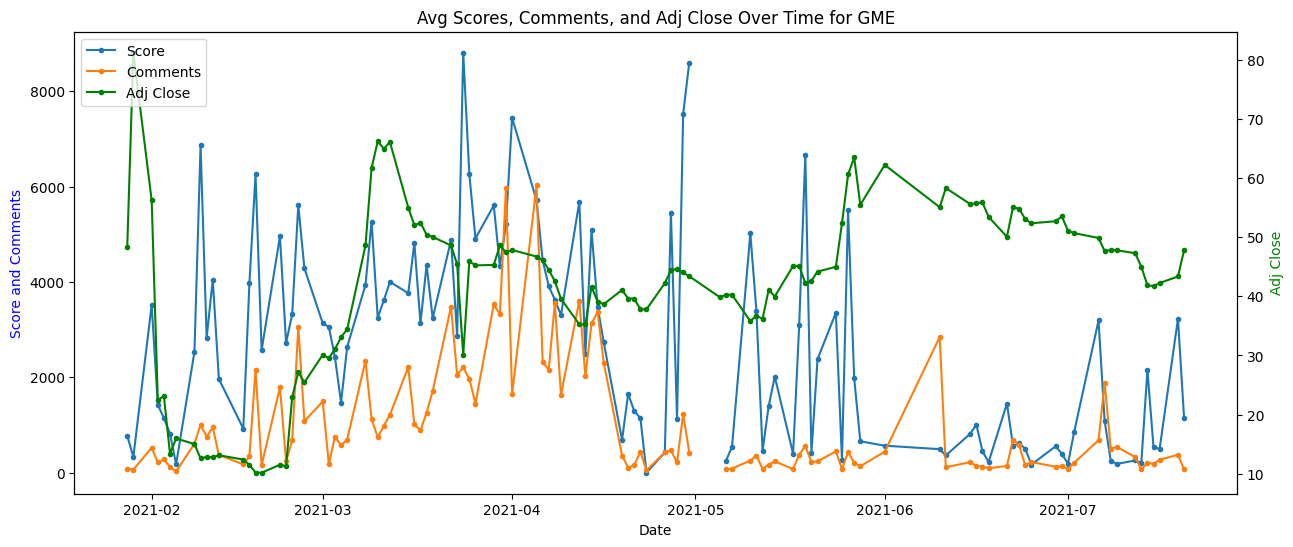

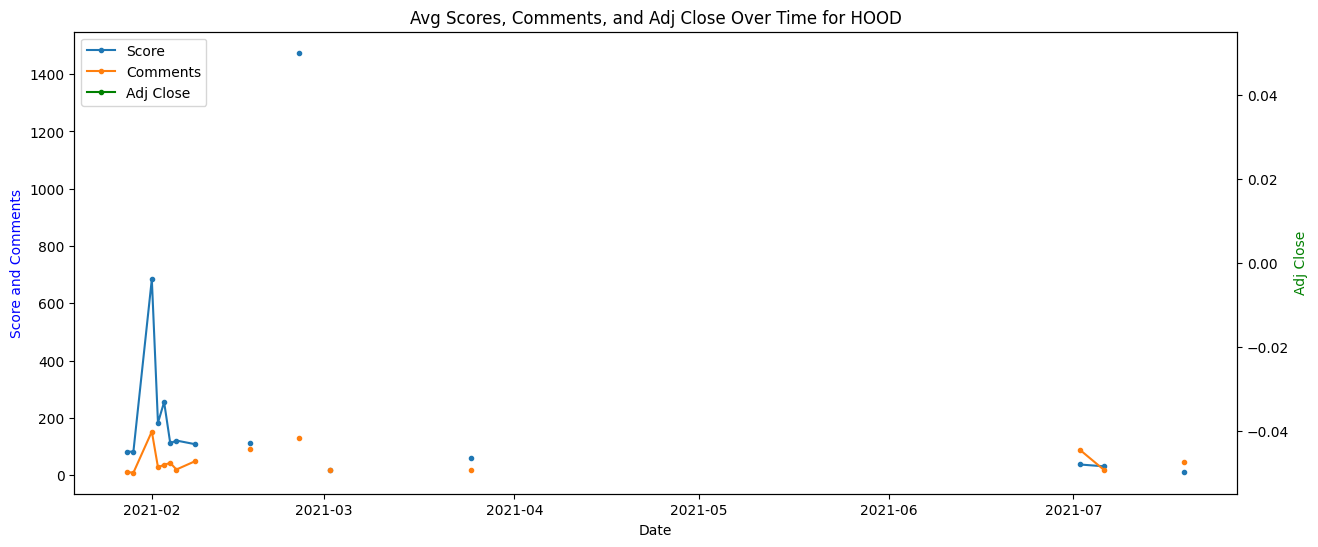

In [50]:
# Plots for each 'stock_symbol' with both 'score' and 'comms_num' in the same axis and Adj Close on a second axis
for stock_symbol in stock_symbols:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    # Plot 'score' and 'comms_num' on the primary y-axis
    ax1.plot(df_merged.index, df_merged['score'][stock_symbol], marker='o', markersize=3, label='Score')
    ax1.plot(df_merged.index, df_merged['comms_num'][stock_symbol], marker='o', markersize=3, label='Comments')

    # Create a secondary y-axis
    ax2 = ax1.twinx()

    # Plot 'Adj Close' on the secondary y-axis
    ax2.plot(df_merged.index, df_merged['Adj Close'][stock_symbol], marker='o', markersize=3, label='Adj Close', color='green')

    ax1.set_xlabel('Date')
    ax1.set_ylabel('Score and Comments', color='blue')
    ax2.set_ylabel('Adj Close', color='green')
    plt.title(f'Avg Scores, Comments, and Adj Close Over Time for {stock_symbol}')

    # Show legend for both axes
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines + lines2, labels + labels2, loc='upper left')

    plt.show()


> Just visualizing the historical data of stock prices of AMC and GME versus the score and number of comments on Reddit, it does not seem that these two have a real effect on stock prices

> Adj Close for HOOD is not available, therefore we will exclude HOOD from the data

In [51]:
# Identify and list the HOOD columns.
hood_columns = [col for col in df_merged.columns if 'HOOD' in col]
hood_columns



[('score', 'HOOD'), ('comms_num', 'HOOD'), ('Adj Close', 'HOOD')]

In [79]:
new_df = df_merged.drop(columns=hood_columns)
new_df

score                comms_num               Adj Close  \
stock_symbol          AMC          GME         AMC         GME         AMC   
2021-01-28     775.586957   772.871795  105.956522   88.451282   86.300003   
2021-01-29      21.960784   330.421670    6.734205   67.054628  132.600006   
2021-02-01    4237.310345  3519.669670  300.344828  524.378378  133.000000   
2021-02-02     338.560000  1425.706161   64.180000  216.886256   78.199997   
2021-02-03    1070.677778  1143.230000   83.055556  277.930000   89.699997   
...                   ...          ...         ...         ...         ...   
2021-07-14     133.000000  2155.333333  492.000000  205.666667  334.299988   
2021-07-15     120.000000   534.000000   93.571429  187.642857  360.000000   
2021-07-16      40.500000   501.333333   39.500000  271.333333  349.600006   
2021-07-19    1102.500000  3229.666667  397.000000  377.666667  346.200012   
2021-07-20     934.000000  1154.000000  331.000000   69.000000  430.899994   

                         
stock_symbol        GME  
2021-01-28    48.400002  
2021-01-29    81.250000  
2021-02-01    56.250000  
2021-02-02    22.500000  
2021-02-03    23.102501  
...                 ...  
2021-07-14    41.904999  
2021-07-15    41.705002  
2021-07-16    42.259998  
2021-07-19    43.372501  
2021-07-20    47.794998  

[110 rows x 6 columns]

## 3. Feature Engineering

Add a labelled data as to define whether the stock price is up or down ?

steps required:
get  labelled data by subtracting the previous day's closing price from the current day's closing price.

### Create AMC dataset with labelled data

In [81]:
df_amc = new_df.xs('AMC', level='stock_symbol', axis=1)
df_amc


,score,comms_num,Adj Close
2021-01-28,775.586957,105.956522,86.300003
2021-01-29,21.960784,6.734205,132.600006
2021-02-01,4237.310345,300.344828,133.000000
2021-02-02,338.560000,64.180000,78.199997
2021-02-03,1070.677778,83.055556,89.699997
...,...,...,...
2021-07-14,133.000000,492.000000,334.299988
2021-07-15,120.000000,93.571429,360.000000
2021-07-16,40.500000,39.500000,349.600006
2021-07-19,1102.500000,397.000000,346.200012


In [82]:
df_amc['Price Change'] = df_amc['Adj Close'].diff()
df_amc['Up_Down'] = df_amc['Price Change'].apply(lambda x: 'Up' if x > 0 else 'Down')
up_down_counts = df_amc['Up_Down'].value_counts()
print(up_down_counts)


Down    57
Up      53
Name: Up_Down, dtype: int64


<ipython-input-82-1669abb8c04d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_amc['Price Change'] = df_amc['Adj Close'].diff()
<ipython-input-82-1669abb8c04d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_amc['Up_Down'] = df_amc['Price Change'].apply(lambda x: 'Up' if x > 0 else 'Down')


In [88]:
df_amc = df_amc.dropna()
df_amc

,score,comms_num,Adj Close,Price Change,Up_Down
2021-01-29,21.960784,6.734205,132.600006,46.300003,Up
2021-02-01,4237.310345,300.344828,133.000000,0.399994,Up
2021-02-02,338.560000,64.180000,78.199997,-54.800003,Down
2021-02-03,1070.677778,83.055556,89.699997,11.500000,Up
2021-02-04,378.677419,45.548387,70.900002,-18.799995,Down
...,...,...,...,...,...
2021-07-14,133.000000,492.000000,334.299988,-59.200012,Down
2021-07-15,120.000000,93.571429,360.000000,25.700012,Up
2021-07-16,40.500000,39.500000,349.600006,-10.399994,Down
2021-07-19,1102.500000,397.000000,346.200012,-3.399994,Down


### Create GME Dataset with labelled data

In [83]:
df_gme = new_df.xs('GME', level='stock_symbol', axis=1)
df_gme


,score,comms_num,Adj Close
2021-01-28,772.871795,88.451282,48.400002
2021-01-29,330.421670,67.054628,81.250000
2021-02-01,3519.669670,524.378378,56.250000
2021-02-02,1425.706161,216.886256,22.500000
2021-02-03,1143.230000,277.930000,23.102501
...,...,...,...
2021-07-14,2155.333333,205.666667,41.904999
2021-07-15,534.000000,187.642857,41.705002
2021-07-16,501.333333,271.333333,42.259998
2021-07-19,3229.666667,377.666667,43.372501


In [84]:
df_gme = new_df.xs('GME', level='stock_symbol', axis=1)
df_gme['Price Change'] = df_gme['Adj Close'].diff()
df_gme['Up_Down'] = df_gme['Price Change'].apply(lambda x: 'Up' if x > 0 else 'Down')
up_down_counts = df_gme['Up_Down'].value_counts()
print(up_down_counts)


Down    60
Up      50
Name: Up_Down, dtype: int64


<ipython-input-84-bf4acbae7174>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gme['Price Change'] = df_gme['Adj Close'].diff()
<ipython-input-84-bf4acbae7174>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gme['Up_Down'] = df_gme['Price Change'].apply(lambda x: 'Up' if x > 0 else 'Down')


In [87]:
df_gme = df_gme.dropna()
df_gme

,score,comms_num,Adj Close,Price Change,Up_Down
2021-01-29,330.421670,67.054628,81.250000,32.849998,Up
2021-02-01,3519.669670,524.378378,56.250000,-25.000000,Down
2021-02-02,1425.706161,216.886256,22.500000,-33.750000,Down
2021-02-03,1143.230000,277.930000,23.102501,0.602501,Up
2021-02-04,821.647399,121.728324,13.375000,-9.727501,Down
...,...,...,...,...,...
2021-07-14,2155.333333,205.666667,41.904999,-3.110001,Down
2021-07-15,534.000000,187.642857,41.705002,-0.199997,Down
2021-07-16,501.333333,271.333333,42.259998,0.554996,Up
2021-07-19,3229.666667,377.666667,43.372501,1.112503,Up


## corelation

In [93]:
correlation_matrix = df_gme.corr()
correlation_matrix


<ipython-input-93-62308e52bf74>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_gme.corr()


,score,comms_num,Adj Close,Price Change
score,1.000000,0.549822,-0.159772,-0.048167
comms_num,0.549822,1.000000,0.014012,-0.034721
Adj Close,-0.159772,0.014012,1.000000,0.230396
Price Change,-0.048167,-0.034721,0.230396,1.000000


In [94]:
correlation_matrix = df_amc.corr()
correlation_matrix


<ipython-input-94-385a109677c9>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df_amc.corr()


,score,comms_num,Adj Close,Price Change
score,1.000000,0.446389,-0.058005,0.167305
comms_num,0.446389,1.000000,0.458604,0.289552
Adj Close,-0.058005,0.458604,1.000000,0.120725
Price Change,0.167305,0.289552,0.120725,1.000000


## Model Building

 Apply classification model on both the models

In [89]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer


df = df_gme

X = df[['score', 'comms_num', 'Adj Close', 'Price Change']]
y = df['Up_Down']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
classifier = RandomForestClassifier(random_state=42)

# Train the model
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        Down       1.00      0.91      0.95        11
          Up       0.92      1.00      0.96        11

    accuracy                           0.95        22
   macro avg       0.96      0.95      0.95        22
weighted avg       0.96      0.95      0.95        22



In [90]:

df = df_amc

X = df[['score', 'comms_num', 'Adj Close', 'Price Change']]
y = df['Up_Down']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the classifier
classifier = RandomForestClassifier(random_state=42)

# Train the model
classifier.fit(X_train, y_train)

# Make predictions
y_pred = classifier.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        Down       1.00      1.00      1.00        12
          Up       1.00      1.00      1.00         8

    accuracy                           1.00        20
   macro avg       1.00      1.00      1.00        20
weighted avg       1.00      1.00      1.00        20



In [91]:
# This means there are  correlated features with dependent and independent data